In [ ]:
from plotnine import *
import pandas as pd
import numpy as np

In [17]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"



df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["n_clusters"] == 100]
df = df[(df["test_negative_sharpe_ratio"] >= 0.2) | (df["test_sharpe_ratio"] >= 0.2)]

df

,window,train_sum_annualized_return,train_sum_actual_return,train_n_trades,test_sum_annualized_return,test_sum_actual_return,test_n_trades,train_cumsum_annualized_return,train_cumsum_actual_return,train_sharpe_ratio,test_cumsum_annualized_return,test_cumsum_actual_return,test_sharpe_ratio,test_negative_sharpe_ratio,n_clusters,algorithm,train_size,test_size,random_state
2666,20,2.00,200,341,-0.26,-26,73,2.00,200,3.989681,-0.26,-26,-0.327247,0.256056,100,gaussian_mixture,3840,960,141
2667,21,1.54,154,287,-0.49,-49,77,3.54,354,3.989681,-0.75,-75,-0.327247,0.256056,100,gaussian_mixture,3840,960,141
2668,22,1.71,171,304,-0.21,-21,72,5.25,525,3.989681,-0.96,-96,-0.327247,0.256056,100,gaussian_mixture,3840,960,141
2669,23,1.53,153,267,0.14,14,49,6.78,678,3.989681,-0.82,-82,-0.327247,0.256056,100,gaussian_mixture,3840,960,141
2670,24,1.99,199,283,-0.07,-7,70,8.77,877,3.989681,-0.89,-89,-0.327247,0.256056,100,gaussian_mixture,3840,960,141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98141,46,1.65,165,323,0.18,18,41,43.20,4320,4.171836,1.26,126,0.231476,-0.340200,100,kmeans,5760,960,115
98142,47,1.37,137,339,-0.15,-15,44,44.57,4457,4.171836,1.11,111,0.231476,-0.340200,100,kmeans,5760,960,115
98143,48,1.16,116,261,0.15,15,54,45.73,4573,4.171836,1.26,126,0.231476,-0.340200,100,kmeans,5760,960,115
98144,49,1.07,107,336,0.18,18,67,46.80,4680,4.171836,1.44,144,0.231476,-0.340200,100,kmeans,5760,960,115


/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


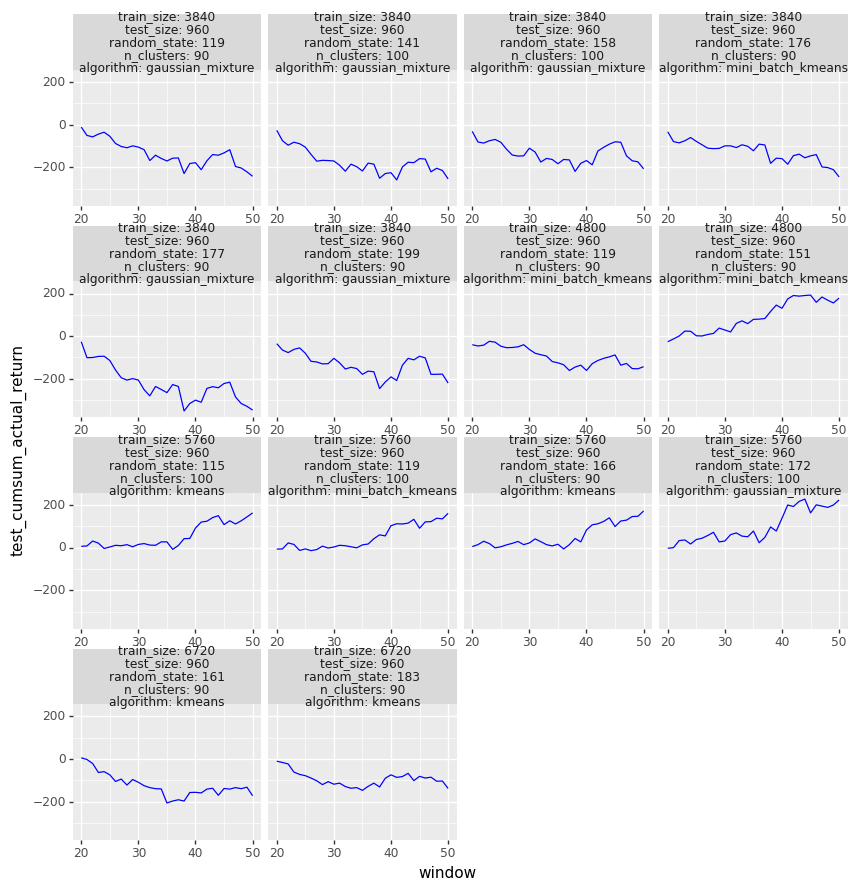

In [18]:
p = ggplot(df)
# p = p + geom_line(aes(x="window", y="train_cumsum_annualized_return"), color="red")
p = p + geom_line(aes(x="window", y="test_cumsum_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_size + random_state", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_size + test_size + random_state + n_clusters + algorithm", scales="free_x", labeller="label_both")
# p = p + theme(figure_size=(30, 30))
p = p + theme(figure_size=(10, 10))
print(p)

In [ ]:

time = "2024-03-14_19:00"
df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/kmeans/results/{time}_results.csv")

p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumsum_annualized_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_cumsum_annualized_return"), color="red")
p = p + facet_wrap("~train_size + test_size + random_state", scales="free_x", labeller="label_both")
p = p + theme(axis_text_x=element_text(angle=90), figure_size=(30, 30))
print(p)

In [ ]:
4 * 24 * 20